In [ ]:
pip install praw pandas
pip install scikit-learn

In [4]:
import praw
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import re
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
import nltk
from nltk.corpus import stopwords
import string

In [ ]:
flairs_list = ["AskIndia", "Non-Political", "Coronavirus", "Scheduled", "Photography", "Science/Technology", "Politics", "Business/Finance", "Policy/Economy", "Sports", "Food"]
attributes = {"flair":[], "title":[], "url":[],"body":[], "comments":[]}

reddit = praw.Reddit(client_id='##', client_secret='##', user_agent='Scrapping Reddit_data')
subreddit = reddit.subreddit('india')
for flair in flairs_list:
  
  get_subreddits = subreddit.search(flair, limit= 80)
  
  for submission in get_subreddits:
    
    attributes["flair"].append(flair)
    attributes["title"].append(submission.title)
    attributes["url"].append(submission.url)
    attributes["body"].append(submission.selftext)
    
    submission.comments.replace_more(limit=None)
    comment = ''
    for top_level_comment in submission.comments:
      comment = comment + ' ' + top_level_comment.body
    attributes["comments"].append(comment)
    

In [ ]:
attributes = pd.DataFrame(attributes)
attributes.to_csv('Reddit_India_Data.csv', index=True)

In [5]:
posts_data = pd.read_csv('Reddit_India_Data.csv')

posts_data['title'] = posts_data['title'].astype(str)
posts_data['url'] = posts_data['url'].astype(str)
posts_data['body'] = posts_data['body'].astype(str)
posts_data['comments'] = posts_data['comments'].astype(str)

space_symbols = re.compile('[/(){}\[\]\|@,;]')
delete_symbols = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def cleaning(text):
    text = text.lower()
    text = space_symbols.sub(' ', text)
    text = delete_symbols.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

posts_data['title'] = posts_data['title'].apply(cleaning)
posts_data['body'] = posts_data['body'].apply(cleaning)
posts_data['comments'] = posts_data['comments'].apply(cleaning)
posts_data.head()

,Unnamed: 0,flair,title,url,body,comments
0,0,AskIndia,4 days ago pending orders 100 million hydroxyc...,https://www.reddit.com/r/india/comments/fwjdqr...,getting frantic calls pharma customers delayed...,modi stockholm syndrome fair evidence chloroqu...
1,1,AskIndia,randians big time users dating apps like tinde...,https://www.reddit.com/r/india/comments/fizkkk...,id stint apps couple months one point didnt fe...,someone matched tell im fat cat 1 general foll...
2,2,AskIndia,r india thinks flat earthers,https://www.reddit.com/r/india/comments/f25vx0...,encountered foreigner ig says round earth hoax...,havent found indian yet believes earth flat de...
3,3,AskIndia,people left 9 5 jobs pursue career music art f...,https://www.reddit.com/r/india/comments/dtvliq...,couldnt add askindia flair mobile browser,engineer advertisement shoots since last 1year...
4,4,AskIndia,somebody want kill full family,https://www.reddit.com/r/india/comments/b7pvwt...,24hrs local police station register case dont ...,calm downgo sp office town file grievance imme...


{'AskIndia': 157.8, 'Non-Political': 107.7625, 'Coronavirus': 47.25, 'Scheduled': 163.4125, 'Photography': 76.775, 'Science/Technology': 240.375, 'Politics': 230.2, 'Business/Finance': 187.95, 'Policy/Economy': 159.4125, 'Sports': 142.575, 'Food': 154.625}


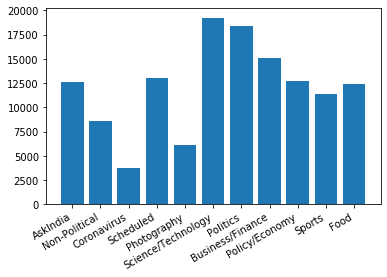

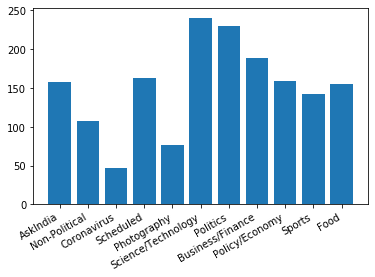

In [6]:
posts_data.rename(columns={'Unnamed: 0':'Index'})
posts_data['COMBINED']= posts_data['title'] + posts_data['comments'] 
posts_data['Unique_words'] = posts_data['COMBINED'].apply(lambda comment: len(set(w for w in comment.split())))
flairs_unique_words_sum = {"AskIndia": posts_data.loc[0:79, 'Unique_words'].sum(), "Non-Political": posts_data.loc[80:159, 'Unique_words'].sum(), "Coronavirus": posts_data.loc[160:239, 'Unique_words'].sum(), "Scheduled": posts_data.loc[240:319, 'Unique_words'].sum(), "Photography": posts_data.loc[320:399, 'Unique_words'].sum(), "Science/Technology": posts_data.loc[400:479, 'Unique_words'].sum(), "Politics": posts_data.loc[480:559, 'Unique_words'].sum(), "Business/Finance": posts_data.loc[560:639, 'Unique_words'].sum(), "Policy/Economy": posts_data.loc[640:719, 'Unique_words'].sum(), "Sports": posts_data.loc[720:799, 'Unique_words'].sum(), "Food": posts_data.loc[800:879, 'Unique_words'].sum()}
flairs_unique_words_mean = {"AskIndia": posts_data.loc[0:79, 'Unique_words'].mean(), "Non-Political": posts_data.loc[80:159, 'Unique_words'].mean(), "Coronavirus": posts_data.loc[160:239, 'Unique_words'].mean(), "Scheduled": posts_data.loc[240:319, 'Unique_words'].mean(), "Photography": posts_data.loc[320:399, 'Unique_words'].mean(), "Science/Technology": posts_data.loc[400:479, 'Unique_words'].mean(), "Politics": posts_data.loc[480:559, 'Unique_words'].mean(), "Business/Finance": posts_data.loc[560:639, 'Unique_words'].mean(), "Policy/Economy": posts_data.loc[640:719, 'Unique_words'].mean(), "Sports": posts_data.loc[720:799, 'Unique_words'].mean(), "Food": posts_data.loc[800:879, 'Unique_words'].mean()}
print(flairs_unique_words_mean)
x = flairs_unique_words_sum.keys()
y = flairs_unique_words_sum.values()
z = flairs_unique_words_mean.values()
plt.bar(x,y)
plt.gcf().autofmt_xdate()
plt.show()
plt.bar(x,z)
plt.gcf().autofmt_xdate()
plt.show()

# MODELS TEST, TRAIN
##  I based my final approach using Linear Support Vector Machine Algorithm which demonstrated optimum accuracy during the training and testing phase. I have also tried implementing the Naive Bayes, Logistic Regression, MLP Classifier and Random Forest algorithms to check the accuracy of the model with these algorithms. 
### After careful observations throughout the overall prediction accuracies, the model has been created on the basis of COMBINED: Title+Comments, using Linear SVM algorithm.

In [7]:
def nb_classifier(X_train, X_test, y_train, y_test):
  
  from sklearn.naive_bayes import MultinomialNB


  nb = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB()),
                ])
  nb.fit(X_train, y_train)

  y_pred = nb.predict(X_test)

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=flairs))

def train_test(X,y):
 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

  print("Results of Naive Bayes Classifier")
  nb_classifier(X_train, X_test, y_train, y_test)
    
flairs = ["AskIndia", "Non-Political", "Coronavirus", "Scheduled", "Photography", "Science/Technology", "Politics", "Business/Finance", "Policy/Economy", "Sports", "Food"]
output = posts_data.flair
Combined_Input = posts_data.COMBINED
Comments_Input = posts_data.comments
Title_Input = posts_data.title
Body_Input = posts_data.body
URL_Input = posts_data.url

print("Flair Detection using Title as Feature")
train_test(Title_Input, output)
print("Flair Detection using Body as Feature")
train_test(Body_Input,output)
print("Flair Detection using URL as Feature")
train_test(URL_Input,output)
print("Flair Detection using Comments as Feature")
train_test(Comments_Input,output)
print("Flair Detection using Title and Comments as Feature")
train_test(Combined_Input,output)

Flair Detection using Title as Feature
Results of Naive Bayes Classifier
accuracy 0.6704545454545454
                    precision    recall  f1-score   support

          AskIndia       0.64      0.69      0.67        26
     Non-Political       0.69      0.39      0.50        23
       Coronavirus       0.58      0.86      0.69        21
         Scheduled       0.81      0.81      0.81        26
       Photography       0.41      0.89      0.56        18
Science/Technology       0.83      0.96      0.89        25
          Politics       0.50      0.56      0.53        25
  Business/Finance       0.70      0.52      0.60        27
    Policy/Economy       0.93      0.48      0.63        27
            Sports       0.81      0.50      0.62        26
              Food       0.85      0.85      0.85        20

          accuracy                           0.67       264
         macro avg       0.70      0.68      0.67       264
      weighted avg       0.71      0.67      0.67       2

F:\JUPYTER\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\JUPYTER\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.3560606060606061
                    precision    recall  f1-score   support

          AskIndia       0.15      0.15      0.15        26
     Non-Political       0.23      0.61      0.34        23
       Coronavirus       0.16      0.24      0.19        21
         Scheduled       0.68      0.65      0.67        26
       Photography       0.17      0.22      0.20        18
Science/Technology       0.88      0.56      0.68        25
          Politics       0.33      0.28      0.30        25
  Business/Finance       0.50      0.52      0.51        27
    Policy/Economy       1.00      0.07      0.14        27
            Sports       0.67      0.08      0.14        26
              Food       0.39      0.55      0.46        20

          accuracy                           0.36       264
         macro avg       0.47      0.36      0.34       264
      weighted avg       0.49      0.36      0.35       264

Flair Detection using Title and Comments as Feature
Results of Naive 

In [8]:
def logisticreg(X_train, X_test, y_train, y_test):

  from sklearn.linear_model import LogisticRegression

  logreg = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', LogisticRegression(n_jobs=1, C=10000)),
                 ])
  logreg.fit(X_train, y_train)

  y_pred = logreg.predict(X_test)

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=flairs))
    
def train_test(X,y):
 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

  print("Results of Logistic Regression")
  logisticreg(X_train, X_test, y_train, y_test)

output = posts_data.flair
Combined_Input = posts_data.COMBINED
Comments_Input = posts_data.comments
Title_Input = posts_data.title
Body_Input = posts_data.body
URL_Input = posts_data.url

print("Flair Detection using Title as Feature")
train_test(Title_Input, output)
print("Flair Detection using Body as Feature")
train_test(Body_Input,output)
print("Flair Detection using URL as Feature")
train_test(URL_Input,output)
print("Flair Detection using Comments as Feature")
train_test(Comments_Input,output)
print("Flair Detection using Title and Comments as Feature")
train_test(Combined_Input,output)


Flair Detection using Title as Feature
Results of Logistic Regression


F:\JUPYTER\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.7272727272727273
                    precision    recall  f1-score   support

          AskIndia       0.60      0.81      0.69        26
     Non-Political       0.50      0.43      0.47        23
       Coronavirus       0.77      0.95      0.85        21
         Scheduled       0.88      0.85      0.86        26
       Photography       0.89      0.89      0.89        18
Science/Technology       0.85      0.92      0.88        25
          Politics       0.54      0.56      0.55        25
  Business/Finance       0.72      0.78      0.75        27
    Policy/Economy       0.80      0.59      0.68        27
            Sports       0.71      0.46      0.56        26
              Food       0.81      0.85      0.83        20

          accuracy                           0.73       264
         macro avg       0.73      0.74      0.73       264
      weighted avg       0.73      0.73      0.72       264

Flair Detection using Body as Feature
Results of Logistic Regression


F:\JUPYTER\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.36363636363636365
                    precision    recall  f1-score   support

          AskIndia       0.50      0.62      0.55        26
     Non-Political       0.47      0.65      0.55        23
       Coronavirus       0.16      0.95      0.27        21
         Scheduled       0.75      0.12      0.20        26
       Photography       0.38      0.17      0.23        18
Science/Technology       0.93      0.56      0.70        25
          Politics       0.44      0.32      0.37        25
  Business/Finance       0.33      0.04      0.07        27
    Policy/Economy       0.55      0.22      0.32        27
            Sports       0.67      0.08      0.14        26
              Food       0.62      0.40      0.48        20

          accuracy                           0.36       264
         macro avg       0.53      0.37      0.35       264
      weighted avg       0.53      0.36      0.35       264

Flair Detection using URL as Feature
Results of Logistic Regression


F:\JUPYTER\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
F:\JUPYTER\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.29924242424242425
                    precision    recall  f1-score   support

          AskIndia       0.17      1.00      0.30        26
     Non-Political       0.00      0.00      0.00        23
       Coronavirus       0.58      0.71      0.64        21
         Scheduled       0.53      0.31      0.39        26
       Photography       0.06      0.06      0.06        18
Science/Technology       0.57      0.16      0.25        25
          Politics       0.80      0.16      0.27        25
  Business/Finance       0.53      0.30      0.38        27
    Policy/Economy       0.17      0.07      0.10        27
            Sports       0.58      0.27      0.37        26
              Food       0.80      0.20      0.32        20

          accuracy                           0.30       264
         macro avg       0.44      0.29      0.28       264
      weighted avg       0.44      0.30      0.28       264

Flair Detection using Comments as Feature
Results of Logistic Regres

F:\JUPYTER\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.4356060606060606
                    precision    recall  f1-score   support

          AskIndia       0.22      0.19      0.20        26
     Non-Political       0.38      0.48      0.42        23
       Coronavirus       0.18      0.29      0.22        21
         Scheduled       0.64      0.69      0.67        26
       Photography       0.20      0.33      0.25        18
Science/Technology       0.77      0.68      0.72        25
          Politics       0.40      0.32      0.36        25
  Business/Finance       0.50      0.56      0.53        27
    Policy/Economy       0.69      0.41      0.51        27
            Sports       0.64      0.27      0.38        26
              Food       0.50      0.55      0.52        20

          accuracy                           0.44       264
         macro avg       0.47      0.43      0.44       264
      weighted avg       0.48      0.44      0.44       264

Flair Detection using Title and Comments as Feature
Results of Logist

F:\JUPYTER\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.6477272727272727
                    precision    recall  f1-score   support

          AskIndia       0.42      0.31      0.36        26
     Non-Political       0.48      0.52      0.50        23
       Coronavirus       0.67      0.76      0.71        21
         Scheduled       0.85      0.85      0.85        26
       Photography       0.54      0.78      0.64        18
Science/Technology       0.88      0.88      0.88        25
          Politics       0.48      0.52      0.50        25
  Business/Finance       0.61      0.63      0.62        27
    Policy/Economy       0.79      0.70      0.75        27
            Sports       0.67      0.46      0.55        26
              Food       0.73      0.80      0.76        20

          accuracy                           0.65       264
         macro avg       0.65      0.66      0.65       264
      weighted avg       0.65      0.65      0.64       264



In [9]:
def randomforest(X_train, X_test, y_train, y_test):
  
  from sklearn.ensemble import RandomForestClassifier
  
  ranfor = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', RandomForestClassifier(n_estimators = 1000, random_state = 42)),
                 ])
  ranfor.fit(X_train, y_train)

  y_pred = ranfor.predict(X_test)

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=flairs))
    
def train_test(X,y):
 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

  print("Results of Random Forest")
  randomforest(X_train, X_test, y_train, y_test)

output = posts_data.flair
Combined_Input = posts_data.COMBINED
Comments_Input = posts_data.comments
Title_Input = posts_data.title
Body_Input = posts_data.body
URL_Input = posts_data.url

print("Flair Detection using Title as Feature")
train_test(Title_Input, output)
print("Flair Detection using Body as Feature")
train_test(Body_Input,output)
print("Flair Detection using URL as Feature")
train_test(URL_Input,output)
print("Flair Detection using Comments as Feature")
train_test(Comments_Input,output)
print("Flair Detection using Title and Comments as Feature")
train_test(Combined_Input,output)


Flair Detection using Title as Feature
Results of Random Forest
accuracy 0.7272727272727273
                    precision    recall  f1-score   support

          AskIndia       0.58      0.73      0.64        26
     Non-Political       0.62      0.43      0.51        23
       Coronavirus       0.77      0.95      0.85        21
         Scheduled       0.92      0.85      0.88        26
       Photography       1.00      0.94      0.97        18
Science/Technology       0.88      0.88      0.88        25
          Politics       0.40      0.68      0.51        25
  Business/Finance       0.81      0.78      0.79        27
    Policy/Economy       0.88      0.52      0.65        27
            Sports       0.80      0.46      0.59        26
              Food       0.75      0.90      0.82        20

          accuracy                           0.73       264
         macro avg       0.76      0.74      0.74       264
      weighted avg       0.76      0.73      0.73       264

Flair

F:\JUPYTER\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.42424242424242425
                    precision    recall  f1-score   support

          AskIndia       0.31      0.15      0.21        26
     Non-Political       0.22      0.26      0.24        23
       Coronavirus       0.19      0.62      0.30        21
         Scheduled       0.64      0.69      0.67        26
       Photography       0.08      0.06      0.07        18
Science/Technology       0.56      0.72      0.63        25
          Politics       0.78      0.28      0.41        25
  Business/Finance       0.55      0.59      0.57        27
    Policy/Economy       0.73      0.41      0.52        27
            Sports       0.71      0.19      0.30        26
              Food       0.52      0.65      0.58        20

          accuracy                           0.42       264
         macro avg       0.48      0.42      0.41       264
      weighted avg       0.50      0.42      0.42       264

Flair Detection using Title and Comments as Feature
Results of Rando

In [10]:
def mlpclassifier(X_train, X_test, y_train, y_test):
  
  from sklearn.neural_network import MLPClassifier
  
  mlp = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MLPClassifier(hidden_layer_sizes=(30,30,30))),
                 ])
  mlp.fit(X_train, y_train)

  y_pred = mlp.predict(X_test)

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=flairs))
    
def train_test(X,y):
 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

  print("Results of MLP Classifier")
  mlpclassifier(X_train, X_test, y_train, y_test)

output = posts_data.flair
Combined_Input = posts_data.COMBINED
Comments_Input = posts_data.comments
Title_Input = posts_data.title
Body_Input = posts_data.body
URL_Input = posts_data.url

print("Flair Detection using Title as Feature")
train_test(Title_Input, output)
print("Flair Detection using Body as Feature")
train_test(Body_Input,output)
print("Flair Detection using URL as Feature")
train_test(URL_Input,output)
print("Flair Detection using Comments as Feature")
train_test(Comments_Input,output)
print("Flair Detection using Title and Comments as Feature")
train_test(Combined_Input,output)


Flair Detection using Title as Feature
Results of MLP Classifier
accuracy 0.4810606060606061
                    precision    recall  f1-score   support

          AskIndia       0.53      0.38      0.44        26
     Non-Political       0.33      0.35      0.34        23
       Coronavirus       0.50      0.19      0.28        21
         Scheduled       0.60      0.58      0.59        26
       Photography       0.80      0.44      0.57        18
Science/Technology       0.89      0.68      0.77        25
          Politics       0.39      0.48      0.43        25
  Business/Finance       0.38      0.56      0.45        27
    Policy/Economy       0.32      0.44      0.38        27
            Sports       0.42      0.42      0.42        26
              Food       0.60      0.75      0.67        20

          accuracy                           0.48       264
         macro avg       0.52      0.48      0.48       264
      weighted avg       0.51      0.48      0.48       264

Flai

F:\JUPYTER\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.22727272727272727
                    precision    recall  f1-score   support

          AskIndia       0.00      0.00      0.00        26
     Non-Political       0.13      0.87      0.23        23
       Coronavirus       0.50      0.48      0.49        21
         Scheduled       0.54      0.27      0.36        26
       Photography       0.06      0.06      0.06        18
Science/Technology       0.33      0.12      0.18        25
          Politics       0.45      0.20      0.28        25
  Business/Finance       0.33      0.07      0.12        27
    Policy/Economy       0.24      0.15      0.18        27
            Sports       0.38      0.12      0.18        26
              Food       0.38      0.25      0.30        20

          accuracy                           0.23       264
         macro avg       0.30      0.23      0.22       264
      weighted avg       0.31      0.23      0.21       264

Flair Detection using Comments as Feature
Results of MLP Classifier


F:\JUPYTER\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.3333333333333333
                    precision    recall  f1-score   support

          AskIndia       0.19      0.19      0.19        26
     Non-Political       0.35      0.30      0.33        23
       Coronavirus       0.20      0.43      0.28        21
         Scheduled       0.73      0.42      0.54        26
       Photography       0.30      0.33      0.32        18
Science/Technology       0.88      0.56      0.68        25
          Politics       0.20      0.60      0.30        25
  Business/Finance       0.27      0.11      0.16        27
    Policy/Economy       0.50      0.22      0.31        27
            Sports       0.75      0.12      0.20        26
              Food       0.43      0.45      0.44        20

          accuracy                           0.33       264
         macro avg       0.44      0.34      0.34       264
      weighted avg       0.45      0.33      0.34       264

Flair Detection using Title and Comments as Feature
Results of MLP Cl

In [11]:
def linear_svm(X_train, X_test, y_train, y_test):
  
  from sklearn.linear_model import SGDClassifier

  model = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                 ])
  model.fit(X_train, y_train)
  pickle.dump(model, open('model.pkl', 'wb')) 
  
  y_pred = model.predict(X_test)

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=flairs))

def train_test(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)
  print("Results of Linear Support Vector Machine Classifier")
  linear_svm(X_train, X_test, y_train, y_test)

output = posts_data.flair
Combined_Input = posts_data.COMBINED
Comments_Input = posts_data.comments
Title_Input = posts_data.title
Body_Input = posts_data.body
URL_Input = posts_data.url

print("Flair Detection using Title as Feature")
train_test(Title_Input, output)
print("Flair Detection using Body as Feature")
train_test(Body_Input,output)
print("Flair Detection using URL as Feature")
train_test(URL_Input,output)
print("Flair Detection using Comments as Feature")
train_test(Comments_Input,output)
print("Flair Detection using Title and Comments as Feature")
train_test(Combined_Input,output)

Flair Detection using Title as Feature
Results of Linear Support Vector Machine Classifier
accuracy 0.7424242424242424
                    precision    recall  f1-score   support

          AskIndia       0.72      0.48      0.58        27
     Non-Political       0.59      0.48      0.53        27
       Coronavirus       0.76      1.00      0.86        22
         Scheduled       0.84      0.93      0.88        28
       Photography       0.85      0.96      0.90        23
Science/Technology       0.94      0.85      0.89        20
          Politics       0.57      0.57      0.57        23
  Business/Finance       0.79      0.81      0.80        27
    Policy/Economy       0.62      0.82      0.71        22
            Sports       0.75      0.60      0.67        20
              Food       0.75      0.72      0.73        25

          accuracy                           0.74       264
         macro avg       0.74      0.75      0.74       264
      weighted avg       0.74      0.74

F:\JUPYTER\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.42803030303030304
                    precision    recall  f1-score   support

          AskIndia       0.17      0.22      0.19        27
     Non-Political       0.43      0.48      0.46        27
       Coronavirus       0.17      0.05      0.07        22
         Scheduled       0.61      0.68      0.64        28
       Photography       0.38      0.22      0.28        23
Science/Technology       0.62      0.75      0.68        20
          Politics       0.33      0.26      0.29        23
  Business/Finance       0.42      0.67      0.51        27
    Policy/Economy       0.44      0.32      0.37        22
            Sports       0.44      0.40      0.42        20
              Food       0.50      0.60      0.55        25

          accuracy                           0.43       264
         macro avg       0.41      0.42      0.41       264
      weighted avg       0.41      0.43      0.41       264

Flair Detection using Title and Comments as Feature
Results of Linea

In [12]:
reddit = praw.Reddit(client_id='#', client_secret='#', user_agent='Scrapping Reddit_data')
loaded_model = pickle.load(open('model.pkl', 'rb'))

def detect_flair(url):
    url = str(url)
    submission = reddit.submission(url = url)
    abcd = {"title": [], "comments": []}
    abcd['title'] = submission.title
    submission.comments.replace_more(limit=None)
    comment = ''
    for top_level_comment in submission.comments:
      comment = comment + ' ' + top_level_comment.body
    abcd["comments"].append(comment)
    abcd = pd.DataFrame(abcd)
    abcd['title'] = abcd['title'].astype(str)
    abcd['title'] =abcd['title'].apply(cleaning)
    abcd['comments'] = abcd['comments'].astype(str)
    abcd['comments'] =abcd['comments'].apply(cleaning)
    abcd['com'] = abcd['title'] + abcd['comments'] 
    return loaded_model.predict(abcd['com'])[0]  

subreddit = reddit.subreddit('india')

for submission in subreddit.top(limit=10):
    print(detect_flair(submission.url))

Photography
Policy/Economy


NotFound: received 404 HTTP response

## When we take the limit = 10, the prediction fails after returning 2 outputs, because reddit allows scraping only 2 posts at a time while prediction process while the search parameter is url. In the next kernel we kept 2 as the limit for scraping, predictions are made accurately. 

In [13]:
reddit = praw.Reddit(client_id='#', client_secret='#', user_agent='Scrapping Reddit_data')
loaded_model = pickle.load(open('model.pkl', 'rb'))

def predict(url):
    url = str(url)
    submission = reddit.submission(url = url)
    abcd = {"title": [], "comments": []}
    abcd['title'] = submission.title
    submission.comments.replace_more(limit=None)
    comment = ''
    for top_level_comment in submission.comments:
      comment = comment + ' ' + top_level_comment.body
    abcd["comments"].append(comment)
    abcd = pd.DataFrame(abcd)
    abcd['title'] = abcd['title'].astype(str)
    abcd['title'] =abcd['title'].apply(cleaning)
    abcd['comments'] = abcd['comments'].astype(str)
    abcd['comments'] =abcd['comments'].apply(cleaning)
    abcd['com'] = abcd['title'] + abcd['comments'] 
    return loaded_model.predict(abcd['com'])[0]  

subreddit = reddit.subreddit('india')

for submission in subreddit.top(limit=2):
    print(detect_flair(submission.url))

Photography
Policy/Economy


# Web Application
## The Problems faced during web development.
### The model chosen was Linear Support Vector Machine because loading the Random Forest model was causing repeated errors due to unknown reason, which on going through Stack Overflow I came to know that  this error with ranfor models happen all the time when Flask is used to develop the application.
### Initially the Automated_Testing code snippet was not shared, hence I assumed it that MIDAS would upload  a text file directly in automated testing.html page. Therefore, I was testing the automated testing on an html page that would return output in a json format,but it took almost 3 minutes to return the output, locally. So, on hosting this version on Heroku teh main.html predictions were returning outputs perfectly, but there was an Application time out error every time in Automated_Testing. This was mainly because Heroku allowas an HTTP post request to process and return putput only for 30seconds, and my version took up ro 3 mins. 
### Nextly, I tried to make the model leaner so that the total space taken after deployment decrease, and removed some unecessary dependencies which I thought were required.
### I was stuck with extraction of each new line of urls from the uploaded text file for prediction in json format. So, I tried to strip, split and readlines individually. On top of this the file which is being uploaded was converted into bytes streams which had to be decoded using utf-8.

In [ ]:
import pandas as pd
import flask
import pickle
import praw
import string
import nltk
import re
from nltk.corpus import stopwords
import os
import json
import requests
nltk.download("stopwords")

reddit = praw.Reddit(client_id='#', client_secret='#', user_agent='Scrapping Reddit_data')
subreddit = reddit.subreddit('india')

model = pickle.load(open('model/model.pkl','rb'))

app = flask.Flask(__name__, template_folder='Templates')

@app.route('/', methods=['GET', 'POST'])
def main():
   if flask.request.method == 'GET':
       return(flask.render_template('main.html'))
   if flask.request.method == 'POST':
       url = flask.request.form['url']
       prediction = predict(url)
       return flask.render_template('main.html', result = prediction)

@app.route('/automated_testing', methods=['GET', 'POST'])
def automated_testing():
    if flask.request.method == 'POST':
        upload_file = flask.request.files['upload_file']
        f = upload_file.read()
        f = str(f,"utf-8")
        lines = f.strip('\n')
        url_list = list(lines.split('\n'))
        with open('qwerty.json','w') as abc:
            l = {"datas": []}
            for url in url_list:
                prediction = str(predict(url))
                lido = {url : prediction}
                l["datas"].append(lido)
                json.dump(l, abc)
        with open('qwerty.json','r') as xyz:
            json_object = json.load(xyz)
        return(json_object)

if __name__ == '__main__':
    app.run(port=33507, debug = True)

# Heroku Deployment
### This was my first Heroku Deployment, though I was exposed to repl.it, surge.sh. As mentioned before, the earlier version of the application was deployed, but there was a continuos application error message appearing when the automated testing file was being uploaded. SInce, this is my first Heroku deployment I gave a detailed read through Heroku documentation which led to me understand that Heroku has a rule that the maximum HTTP timeout in their server is only 30 seconds. Hence, every time the automated testing failed. It also led the app to crash multiple times. Just duing this time when I was trying to fix this error, MIDAS mailed the way they are going to send the POST request. Included the key as the mail suggested and tried sending a POST request in a fresh app. The main.html was perfect but again the automated testing failed as the text file with r/india url was pushed to the server. I noticed that on the Heroku terminal the error logs printed the predicted flairs, but did not return the results finally. Lastly, I tried posting a new text file with just 1 url in it, and the POST REQUEST successfully fetched me the result on adding a print(r.text) to the POST request code. Finally, I hosted this again on Heroku and tested with 2 urls, it failed to return flairs. I inferred that the system would return only when 1 url is sent in tje text file. Therefore, this MIDAS task was completed.

import requests

files = {'upload_file': open('reddit.txt','rb')}

r = requests.post("https://flairintity.herokuapp.com/automated_testing", files=files, timeout=350)

print(r.text)


